In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import normalize
from scipy import interp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 


name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list1 = []
list2 = []
list = []
for d in data:
    list1.append(d[0])  
    list2.append(np.int(d[1]))  
    list.append(d)  
list1 = np.asarray(list1)    
list2 = np.asarray(list2)    

In [3]:
print (list)
print ('-------------------------------------------------------------------------------------------------')
print (list2)
print ('-------------------------------------------------------------------------------------------------')
listq = np.unique(list1)
print (listq)
list3 = []
for d in range(len(listq)):
    l = np.where(list1 == listq[d])
    ll = np.argsort(list2[l[0]])[::-1]
    l = l[0]
    list3.append(l[ll]) 

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4', 4), ('G

In [4]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 6
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st],
         list3[10][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((11*(st-1)))
print (listh)
print (list2[listh])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [5]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 1
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 55000


In [6]:
mdl0 = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

/home/lolo/Desktop/dnnComm/vde/vde/utils.py:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight.data)
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
# for some reasons autocorr_loss does behave properly!
mdl0.fit(trajs)

Epoch: 0


/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:271: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  print('Batch %d, loss = %.4f' % (t + 1, loss.data[0]))
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:275: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  'autocorr_loss = %.4f' % (rec_loss.data[0],
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:276: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  autocorr_loss.data[0]))


Batch 100, loss = 0.7223
rec_loss = 0.0323, autocorr_loss = 0.6899
Batch 200, loss = 0.7438
rec_loss = 0.0325, autocorr_loss = 0.7113
Batch 300, loss = 0.8217
rec_loss = 0.0238, autocorr_loss = 0.7979
Batch 400, loss = 0.7944
rec_loss = 0.0181, autocorr_loss = 0.7763
Batch 500, loss = 0.6222
rec_loss = 0.0184, autocorr_loss = 0.6038
Batch 600, loss = 0.4619
rec_loss = 0.0129, autocorr_loss = 0.4490
Batch 700, loss = 0.6275
rec_loss = 0.0161, autocorr_loss = 0.6114
Batch 800, loss = 0.7000
rec_loss = 0.0148, autocorr_loss = 0.6852
Batch 900, loss = 0.5952
rec_loss = 0.0142, autocorr_loss = 0.5810
Batch 1000, loss = 0.5935
rec_loss = 0.0141, autocorr_loss = 0.5794
Batch 1100, loss = 0.6461
rec_loss = 0.0121, autocorr_loss = 0.6340
Batch 1200, loss = 0.5254
rec_loss = 0.0118, autocorr_loss = 0.5136
Batch 1300, loss = 0.7368
rec_loss = 0.0106, autocorr_loss = 0.7262
Batch 1400, loss = 0.4903
rec_loss = 0.0107, autocorr_loss = 0.4796
Batch 1500, loss = 0.5075
rec_loss = 0.0102, autocorr_los

In [8]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


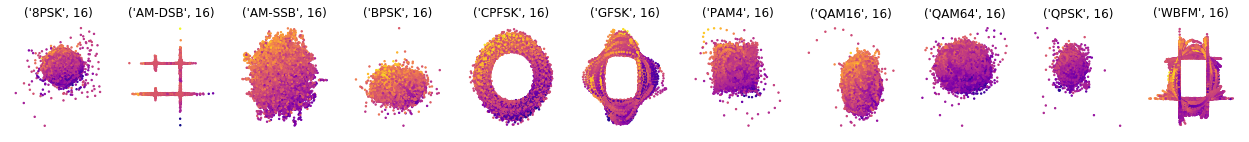

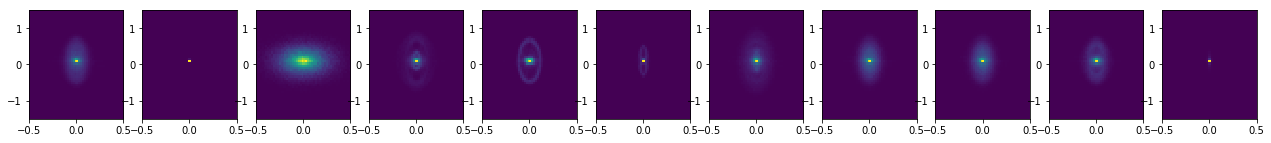

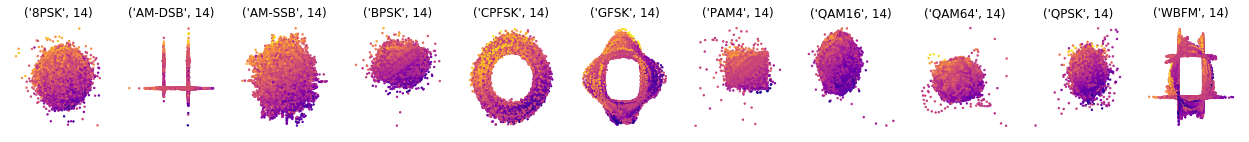

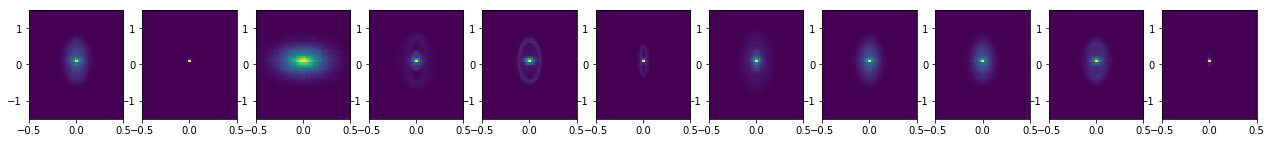

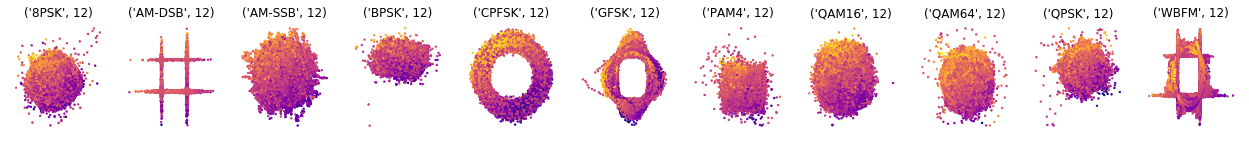

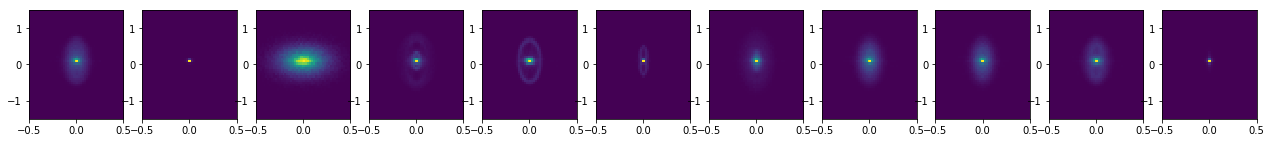

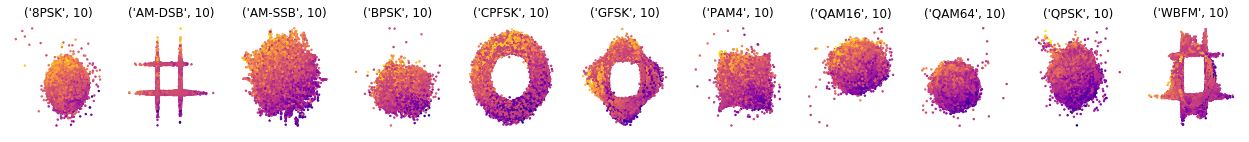

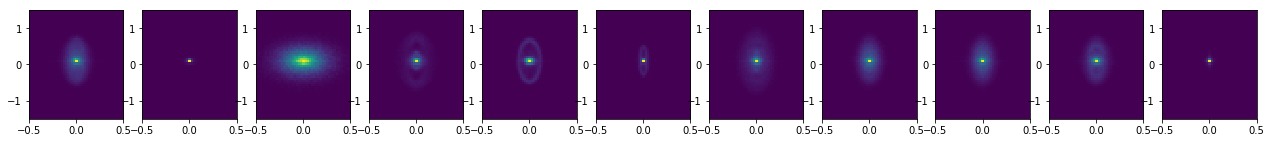

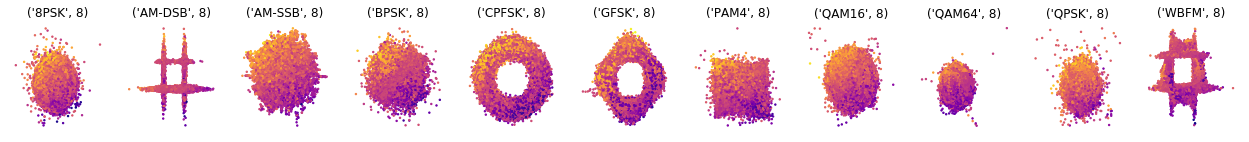

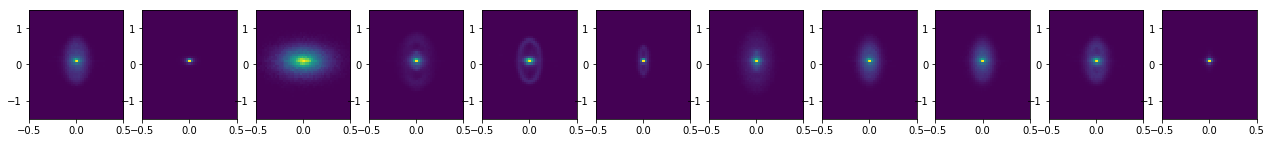

In [9]:
for i in range(st-1):
    fig = plt.figure(figsize=(2*11, 1*2))
    c = 0
    for j in range(11):
            ax1 = fig.add_subplot(1, 11, j+1)
            scatter(mdl0, cmap='plasma_r', l=c*(st-1)+i, ax=ax1)
            ax1.set_title(list[listh[c*(st-1)+i]]); clean_up(ax1)
            c += 1
    plt.savefig('result11'+np.str(i)+'.png')
    #plt.close(fig)

    fig = plt.figure(figsize=(2*11, 1*2))
    c = 0
    for j in range(11):
            ax2 = fig.add_subplot(1, 11, j+1)
            hist(mdl0, cmap='plasma_r', l=c*(st-1)+i, ax=ax2)
            #ax2.set_title('Signature')
            c += 1
    plt.savefig('result12'+np.str(i)+'.png')
    #plt.close(fig)

In [10]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')    
th = 6
listt = [list3[0][th], list3[1][th], list3[2][th], list3[3][th], list3[4][th],
         list3[5][th], list3[6][th], list3[7][th], list3[8][th], list3[9][th],
         list3[10][th]]
listt = np.asarray(listt, dtype=np.int)
print (listt)
print (list2[listt])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [11]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs0 = []
stride = 1
for l in range(len(listt)):
    d = data[list[listt[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs0.append(dddd)
print ('samples,features', trajs0[0].shape)    
print ('#data', len(trajs0))

samples,features (128, 32)
#data 11000


In [12]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs0[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs0[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs0[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


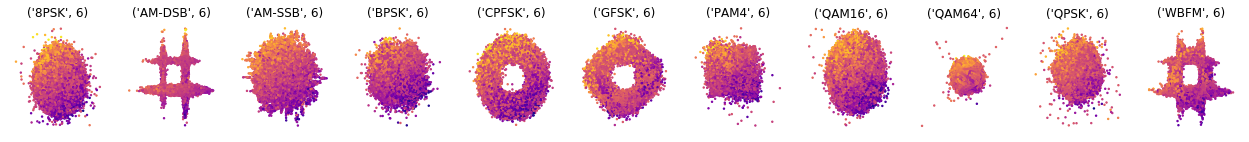

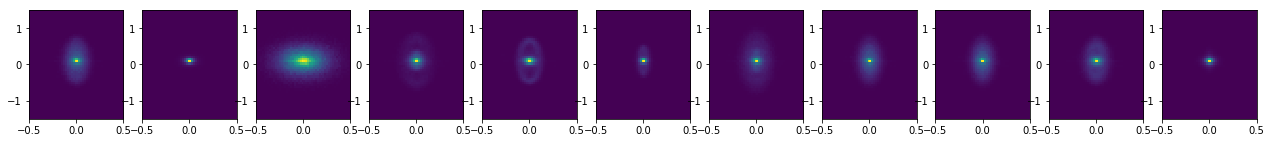

In [13]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl0, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result21.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl0, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result22.png')
#plt.close(fig)

In [14]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 7
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((10*(st-1)))
print (listh)
print (list2[listh])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [15]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 1
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 60000


In [16]:
mdl1 = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [17]:
# for some reasons autocorr_loss does behave properly!
mdl1.fit(trajs)

Epoch: 0
Batch 100, loss = 0.5966
rec_loss = 0.0936, autocorr_loss = 0.5030
Batch 200, loss = 0.7415
rec_loss = 0.0622, autocorr_loss = 0.6793
Batch 300, loss = 0.6851
rec_loss = 0.0408, autocorr_loss = 0.6443
Batch 400, loss = 0.6806
rec_loss = 0.0321, autocorr_loss = 0.6485
Batch 500, loss = 0.5285
rec_loss = 0.0233, autocorr_loss = 0.5052
Batch 600, loss = 0.7636
rec_loss = 0.0179, autocorr_loss = 0.7456
Batch 700, loss = 0.6617
rec_loss = 0.0193, autocorr_loss = 0.6424
Batch 800, loss = 0.6197
rec_loss = 0.0134, autocorr_loss = 0.6064
Batch 900, loss = 0.7501
rec_loss = 0.0120, autocorr_loss = 0.7381
Batch 1000, loss = 0.4818
rec_loss = 0.0140, autocorr_loss = 0.4678
Batch 1100, loss = 0.7838
rec_loss = 0.0123, autocorr_loss = 0.7715
Batch 1200, loss = 0.6432
rec_loss = 0.0130, autocorr_loss = 0.6302
Batch 1300, loss = 0.6133
rec_loss = 0.0133, autocorr_loss = 0.6000
Batch 1400, loss = 0.6342
rec_loss = 0.0104, autocorr_loss = 0.6239
Batch 1500, loss = 0.6401
rec_loss = 0.0101, aut

In [18]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')    
th = 6
listt = [list3[0][th], list3[1][th], list3[2][th], list3[3][th], list3[4][th],
         list3[5][th], list3[6][th], list3[7][th], list3[8][th], list3[9][th],
         list3[10][th]]
listt = np.asarray(listt, dtype=np.int)
print (listt)
print (list2[listt])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [19]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs1 = []
stride = 1
for l in range(len(listt)):
    d = data[list[listt[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs1.append(dddd)
print ('samples,features', trajs1[0].shape)    
print ('#data', len(trajs1))

samples,features (128, 32)
#data 11000


In [20]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition0, decomposition1, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w0 = np.concatenate(decomposition0.transform(trajs0[l*delta:(l+1)*delta]))[::stride].ravel()
    w0 -= w0.min()
    w0 /= w0.max()    
    w1 = np.concatenate(decomposition1.transform(trajs1[l*delta:(l+1)*delta]))[::stride].ravel()
    w1 -= w1.min()
    w1 /= w1.max()
    w = np.abs(w0 - w1)
    w -= w.min()
    w /= w.max()    
    ax.scatter(*np.vstack(trajs1[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)
    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs1[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


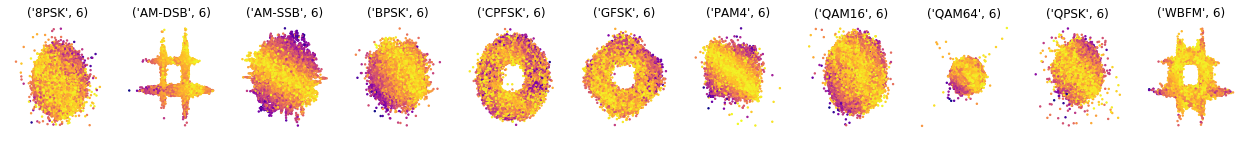

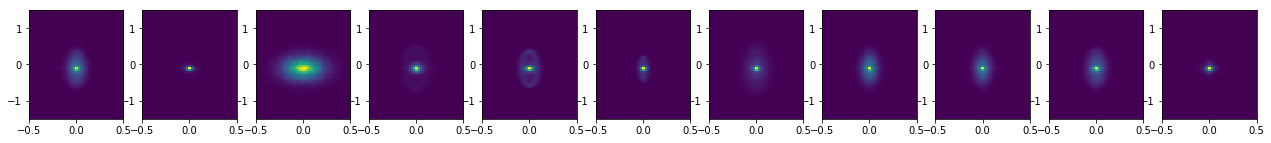

In [21]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl0, mdl1, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result31.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl1, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result32.png')
#plt.close(fig)

In [22]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 7
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st],
         list3[10][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((11*(st-1)))
print (listh)
print (list2[listh])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [23]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 1
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 66000


In [24]:
mdl2 = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [25]:
# for some reasons autocorr_loss does behave properly!
mdl2.fit(trajs)

Epoch: 0
Batch 100, loss = 0.8316
rec_loss = 0.1087, autocorr_loss = 0.7229
Batch 200, loss = 0.9721
rec_loss = 0.0238, autocorr_loss = 0.9484
Batch 300, loss = 0.5408
rec_loss = 0.0238, autocorr_loss = 0.5170
Batch 400, loss = 0.7424
rec_loss = 0.0177, autocorr_loss = 0.7248
Batch 500, loss = 0.6400
rec_loss = 0.0183, autocorr_loss = 0.6218
Batch 600, loss = 0.6255
rec_loss = 0.0199, autocorr_loss = 0.6056
Batch 700, loss = 0.6346
rec_loss = 0.0160, autocorr_loss = 0.6186
Batch 800, loss = 0.5099
rec_loss = 0.0112, autocorr_loss = 0.4988
Batch 900, loss = 0.6978
rec_loss = 0.0122, autocorr_loss = 0.6856
Batch 1000, loss = 0.5864
rec_loss = 0.0129, autocorr_loss = 0.5735
Batch 1100, loss = 0.6408
rec_loss = 0.0134, autocorr_loss = 0.6274
Batch 1200, loss = 0.8756
rec_loss = 0.0132, autocorr_loss = 0.8624
Batch 1300, loss = 0.6544
rec_loss = 0.0108, autocorr_loss = 0.6436
Batch 1400, loss = 0.7013
rec_loss = 0.0116, autocorr_loss = 0.6896
Batch 1500, loss = 0.4416
rec_loss = 0.0131, aut

In [28]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition0, decomposition1, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w0 = np.concatenate(decomposition0.transform(trajs0[np.int(l/((st-1)+st-2))*delta:(np.int(l/((st-1)+st-2))+1)*delta]))[::stride].ravel()
    w0 -= w0.min()
    w0 /= w0.max()    
    w1 = np.concatenate(decomposition1.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w1 -= w1.min()
    w1 /= w1.max()
    w = np.abs(w0 - w1)
    w -= w.min()
    w /= w.max()    
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)
    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


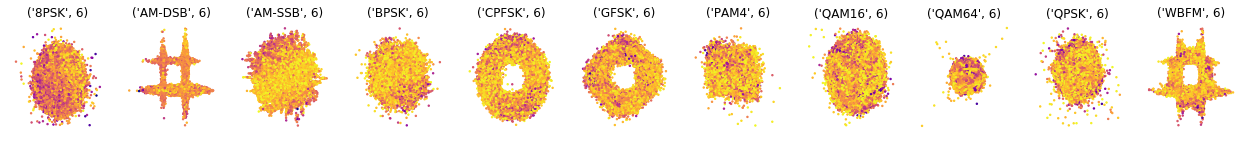

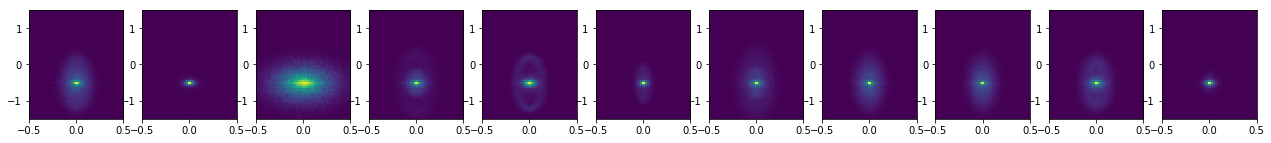

In [29]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl0, mdl2, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result41.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl2, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result42.png')
#plt.close(fig)

In [30]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 7
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st],
         list3[10][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((11*(st-1)))
print (listh)
print (list2[listh])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [31]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 8
trajs = []
stride = 1
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t]*dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)            
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 30)
#data 66000


In [32]:
mdl3 = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [33]:
# for some reasons autocorr_loss does behave properly!
mdl3.fit(trajs)

Epoch: 0
Batch 100, loss = 0.9283
rec_loss = 0.3404, autocorr_loss = 0.5879
Batch 200, loss = 0.6908
rec_loss = 0.1079, autocorr_loss = 0.5829
Batch 300, loss = 0.7532
rec_loss = 0.0521, autocorr_loss = 0.7011
Batch 400, loss = 0.7616
rec_loss = 0.0361, autocorr_loss = 0.7255
Batch 500, loss = 0.7314
rec_loss = 0.0216, autocorr_loss = 0.7098
Batch 600, loss = 0.4424
rec_loss = 0.0269, autocorr_loss = 0.4156
Batch 700, loss = 0.5832
rec_loss = 0.0183, autocorr_loss = 0.5650
Batch 800, loss = 0.6644
rec_loss = 0.0143, autocorr_loss = 0.6502
Batch 900, loss = 0.5783
rec_loss = 0.0183, autocorr_loss = 0.5600
Batch 1000, loss = 0.5295
rec_loss = 0.0115, autocorr_loss = 0.5180
Batch 1100, loss = 0.4833
rec_loss = 0.0119, autocorr_loss = 0.4714
Batch 1200, loss = 0.7048
rec_loss = 0.0112, autocorr_loss = 0.6935
Batch 1300, loss = 0.4394
rec_loss = 0.0094, autocorr_loss = 0.4300
Batch 1400, loss = 0.5333
rec_loss = 0.0096, autocorr_loss = 0.5237
Batch 1500, loss = 0.5649
rec_loss = 0.0076, aut

In [34]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition0, decomposition1, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w0 = np.concatenate(decomposition0.transform(trajs0[np.int(l/((st-1)+st-2))*delta:(np.int(l/((st-1)+st-2))+1)*delta]))[::stride].ravel()
    w0 -= w0.min()
    w0 /= w0.max()    
    w1 = np.concatenate(decomposition1.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w1 -= w1.min()
    w1 /= w1.max()
    w = np.abs(w0 - w1)
    w -= w.min()
    w /= w.max()    
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)
    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


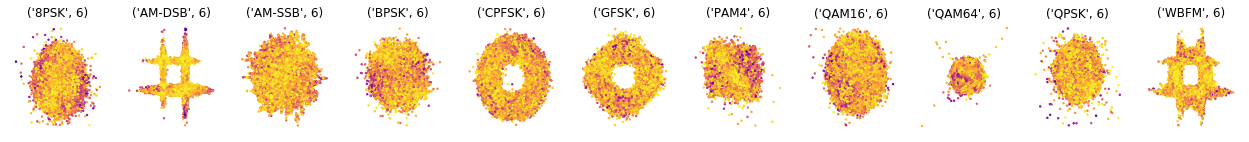

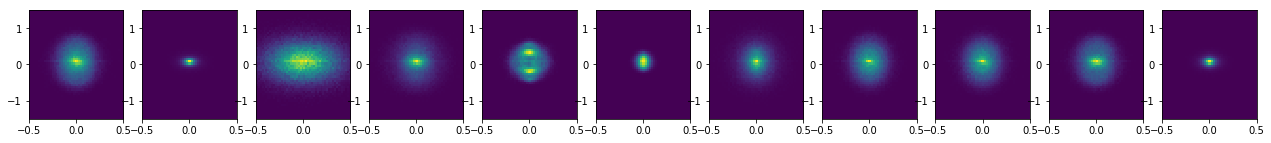

In [35]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl0, mdl3, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result51.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl3, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result5.png')
#plt.close(fig)

In [36]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 7
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st],
         list3[10][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((11*(st-1)))
print (listh)
print (list2[listh])

[array([192, 104, 179,   7,  72,   6, 218, 134, 171,  81, 196, 125, 118,
        45, 116,  29,  62, 109, 195, 110]), array([163,  13, 129, 214, 181,  41,  26, 114,  76, 166, 137,   2, 188,
        50,  34,  66,  84, 174, 115, 103]), array([ 87, 177, 140,   5, 190,  53,  20, 102,  64, 157,  58, 151, 111,
       197, 164,  24, 210,  73,  38, 126]), array([155,  44,  49, 136,  97, 187, 153,  16, 200,  60,  17,  98,  61,
       154,  31, 201, 167,  27, 219, 121]), array([133,  46, 184,  94,  14, 108,  59, 198, 112,  25,  52, 189, 101,
        19, 156,  63, 203, 117,  30, 170]), array([ 54, 204, 122,  35,  68, 206,   3, 138, 175,  85, 128,  40,  75,
       213,  51, 207, 180,  90, 209,  23]), array([ 96, 143,  33, 173,  83,   1, 158,  67, 205, 120, 100,  91,  11,
       148,  77, 215, 130,  42, 162,  71]), array([145, 212, 160,  22, 106, 193,  55, 144,   9,  89, 123, 152,  69,
       161, 142, 107, 194,  56, 146,  10]), array([ 57, 147,  86, 176, 139,   4, 208,  70,  36, 124, 178,  39,   8,

In [37]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 8
trajs = []
stride = 1
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)          
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 16)
#data 66000


In [38]:
mdl4 = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [39]:
# for some reasons autocorr_loss does behave properly!
mdl4.fit(trajs)

Epoch: 0
Batch 100, loss = 0.5447
rec_loss = 0.0548, autocorr_loss = 0.4899
Batch 200, loss = 0.5895
rec_loss = 0.0307, autocorr_loss = 0.5588
Batch 300, loss = 0.3425
rec_loss = 0.0246, autocorr_loss = 0.3179
Batch 400, loss = 0.7530
rec_loss = 0.0183, autocorr_loss = 0.7348
Batch 500, loss = 0.5874
rec_loss = 0.0155, autocorr_loss = 0.5719
Batch 600, loss = 0.6653
rec_loss = 0.0149, autocorr_loss = 0.6504
Batch 700, loss = 0.5199
rec_loss = 0.0093, autocorr_loss = 0.5106
Batch 800, loss = 0.3700
rec_loss = 0.0121, autocorr_loss = 0.3579
Batch 900, loss = 0.5976
rec_loss = 0.0104, autocorr_loss = 0.5872
Batch 1000, loss = 0.5173
rec_loss = 0.0094, autocorr_loss = 0.5079
Batch 1100, loss = 0.7349
rec_loss = 0.0090, autocorr_loss = 0.7259
Batch 1200, loss = 0.4935
rec_loss = 0.0087, autocorr_loss = 0.4848
Batch 1300, loss = 0.4336
rec_loss = 0.0102, autocorr_loss = 0.4234
Batch 1400, loss = 0.5666
rec_loss = 0.0071, autocorr_loss = 0.5595
Batch 1500, loss = 0.4907
rec_loss = 0.0076, aut

In [40]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition0, decomposition1, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w0 = np.concatenate(decomposition0.transform(trajs0[np.int(l/((st-1)+st-2))*delta:(np.int(l/((st-1)+st-2))+1)*delta]))[::stride].ravel()
    w0 -= w0.min()
    w0 /= w0.max()    
    w1 = np.concatenate(decomposition1.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w1 -= w1.min()
    w1 /= w1.max()
    w = np.abs(w0 - w1)
    w -= w.min()
    w /= w.max()    
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)
    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


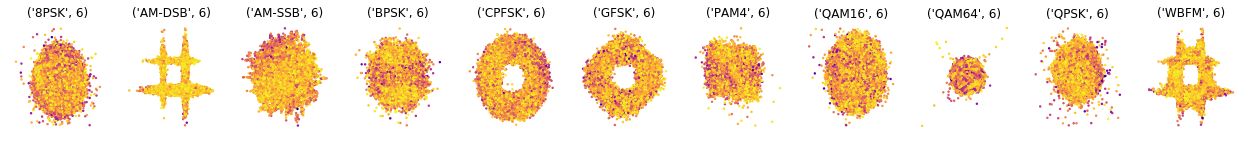

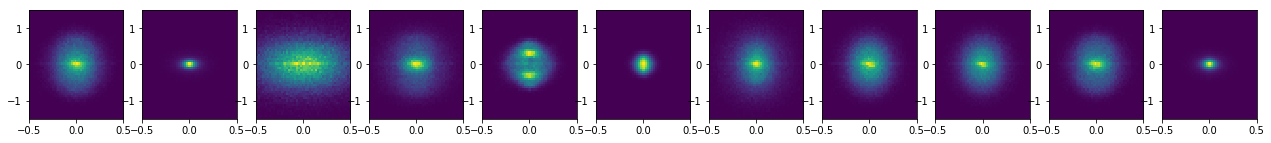

In [41]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl0, mdl4, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result61.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl4, cmap='plasma_r', l=c*(st-1)+st-2, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result62.png')
#plt.close(fig)

In [51]:
import zmq
import array

socket_str = 'tcp://127.0.0.1:5557'


def zmq_consumer(T):
    context = zmq.Context()
    results_receiver = context.socket(zmq.PULL)
    results_receiver.connect(socket_str)
    raw_data = results_receiver.recv()
    float_list = array.array('f', raw_data)
    t = 0
    data = []
    for signal_val in float_list:
        data.append(np.float(signal_val))
        t += 1
        if t >= T: 
            break;
    DATA = np.zeros((T), dtype=np.float)
    DATA[0:len(data)] = data
    return DATA                              

Text(0.5,1,'SDR data')

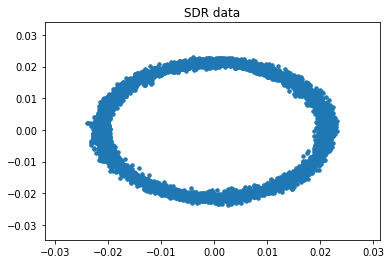

In [52]:
L = 50
T = 128*2*L
data_ = zmq_consumer(T)
plt.figure()
plt.scatter(data_[0:T:2], data_[1:T:2], s=12)
plt.title('SDR data')

In [53]:
lag_time = 16
trajs_test = []

for i in range(np.int(T/(128*2))):
    dd = np.zeros((128, 2))
    dd[:, 0] = data_[i*2*128:(i+1)*2*128:2]
    dd[:, 1] = data_[i*2*128+1:(i+1)*2*128:2]
    dd = normalize(dd, axis=0, norm='l2')
    Dt = dd.shape
    dddd = dd
    for t in range(1, lag_time):
        ddd = np.zeros(Dt)
        ddd[:-t] = dd[:-t] - dd[t:]
        dddd = np.append(dddd, ddd, axis=1)
    trajs_test.append(dddd)
print (len(trajs_test), trajs_test[0].shape)    

50 (128, 32)


In [54]:
def scatter(decomposition, cmap='plasma', stride=1, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs_test[:])[::stride, 0:2].T, c=cmap(w),s=12 )

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50, range=[[-0.5, 0.5], [-1.5, 1.5]])

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

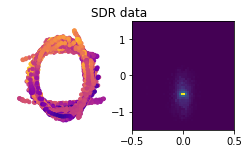

In [55]:
fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
scatter(mdl2, cmap='plasma_r', ax=ax1)
clean_up(ax1)
hist(mdl2, cmap='plasma_r', ax=ax2)
fig.suptitle('SDR data')
plt.savefig('result.png')

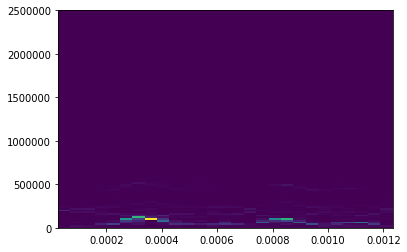

In [56]:
import scipy.signal as sc
w = np.concatenate(mdl2.transform(trajs_test[:]))[::stride].ravel()
fs = 5e6
f, t, Sxx = sc.spectrogram(w, fs)
plt.pcolormesh(t, f, Sxx)
plt.show()